In [1]:
pip install pulp

In [2]:
pip install streamlit prophet pulp seaborn matplotlib


In [19]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [10]:
import pandas as pd

df = pd.read_csv(r"C:\Users\DELL\Desktop\proj\college_budget_enrollment_data_with_year.csv")
df.head()

,College_Name,State,College_Type,Enrollment,Faculty_Count,Total_Budget,Year
0,College_1,Delhi,Private,879,380,37986527,2000
1,College_2,West Bengal,Government,992,177,6119043,2000
2,College_3,Karnataka,Private,2562,397,16718070,2000
3,College_4,West Bengal,Government,4384,280,49149943,2001
4,College_5,West Bengal,Private,564,239,19012538,2002


In [11]:
print(df)

   College_Name        State College_Type  Enrollment  Faculty_Count  \
0     College_1        Delhi      Private         879            380   
1     College_2  West Bengal   Government         992            177   
2     College_3    Karnataka      Private        2562            397   
3     College_4  West Bengal   Government        4384            280   
4     College_5  West Bengal      Private         564            239   
5     College_6   Tamil Nadu   Government        3068            274   
6     College_7    Karnataka      Private        2527            332   
7     College_8    Karnataka   Government        3195            170   
8     College_9    Karnataka   Government        1995            165   
9    College_10  West Bengal      Private         891            282   
10   College_11        Delhi   Government        4974            308   
11   College_12    Karnataka      Private        4061            247   
12   College_13  West Bengal      Private        2778           

In [12]:
print("dataset loaded. shape:",df.shape)

dataset loaded. shape: (50, 7)


In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   College_Name   50 non-null     object
 1   State          50 non-null     object
 2   College_Type   50 non-null     object
 3   Enrollment     50 non-null     int64 
 4   Faculty_Count  50 non-null     int64 
 5   Total_Budget   50 non-null     int64 
 6   Year           50 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 2.9+ KB
None


In [14]:
print(df.describe())

       Enrollment  Faculty_Count  Total_Budget         Year
count    50.00000      50.000000  5.000000e+01    50.000000
mean   2707.24000     236.320000  2.927469e+07  2006.060000
std    1262.82071      84.668969  1.285154e+07     8.087304
min     564.00000      51.000000  6.119043e+06  2000.000000
25%    1635.00000     171.250000  1.804565e+07  2000.000000
50%    2866.00000     232.500000  2.998809e+07  2000.000000
75%    3602.75000     282.000000  4.047605e+07  2011.750000
max    4993.00000     397.000000  4.914994e+07  2025.000000


In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your dataset (already fixed previously)
df = pd.read_csv(r"C:\Users\DELL\Desktop\proj\college_budget_enrollment_data_with_year.csv")

# --- Data Preprocessing ---

# Handling missing values
df.fillna(df.mean(numeric_only=True), inplace=True)

# Feature Engineering
df['Budget_per_Student'] = df['Total_Budget'] / df['Enrollment']
df['Student_Faculty_Ratio'] = df['Enrollment'] / df['Faculty_Count']

# Encoding categorical variables
df = pd.get_dummies(df, columns=['State', 'College_Type'], drop_first=True)

# Define features and target
features = df.drop(columns=['Total_Budget', 'College_Name'])
target = df['Total_Budget']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [20]:
# --- 4. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)


In [21]:
# --- 5. Model Training ---
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

In [22]:
# --- 6. Display Results ---
print("Model Performance Summary:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


Model Performance Summary:

LinearRegression:
  RMSE: 6817080.4764
  R2: 0.6025

Ridge:
  RMSE: 6397308.1854
  R2: 0.6499

Lasso:
  RMSE: 6817079.7548
  R2: 0.6025

RandomForest:
  RMSE: 8875366.3580
  R2: 0.3262


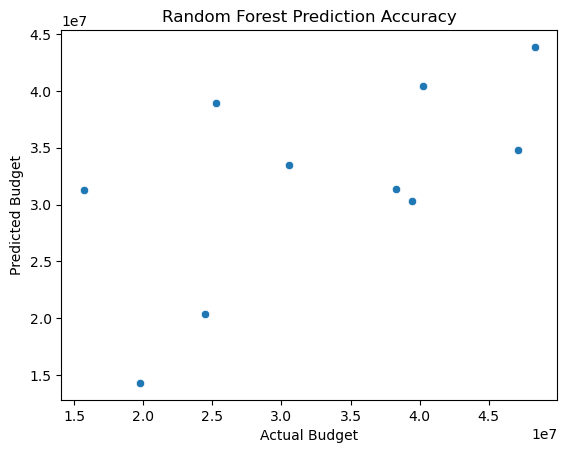

In [23]:
# --- 7. Visualization ---
sns.scatterplot(x=y_test, y=models['RandomForest'].predict(X_test))
plt.xlabel("Actual Budget")
plt.ylabel("Predicted Budget")
plt.title("Random Forest Prediction Accuracy")
plt.show()


In [24]:
# --- 8. Save Model (Optional) ---
import joblib
joblib.dump(models['RandomForest'], 'budget_predictor_rf.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Add this

['scaler.pkl']

In [25]:
# --- 9. Optimization Suggestion ---
# Store original features for prediction
features_original = df.drop(columns=['Total_Budget', 'College_Name'])
df['Predicted_Budget'] = models['RandomForest'].predict(scaler.transform(features_original))
df['Budget_Deficit'] = df['Predicted_Budget'] - df['Total_Budget']

In [26]:
# Suggest colleges needing more funds
deficit_colleges = df[df['Budget_Deficit'] > 0][['College_Name', 'Predicted_Budget', 'Total_Budget', 'Budget_Deficit']]
deficit_colleges = deficit_colleges.sort_values(by='Budget_Deficit', ascending=False)
print("\nTop 10 Colleges Needing More Funds:")
print(deficit_colleges.head(10))

from sklearn.model_selection import cross_val_score

for name, model in models.items():
    scores = cross_val_score(model, features_scaled, target, cv=5, scoring='r2')
    print(f"{name} - Cross-Validated R²: {scores.mean():.4f} ± {scores.std():.4f}")

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                           cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)



Top 10 Colleges Needing More Funds:
   College_Name  Predicted_Budget  Total_Budget  Budget_Deficit
30   College_31       31315701.00      15700595     15615106.00
48   College_49       38946418.46      25281689     13664729.46
9    College_10       18543852.93      11659908      6883944.93
31   College_32       24317643.12      17984808      6332835.12
4     College_5       23206884.08      19012538      4194346.08
36   College_37       25083280.93      21385802      3697478.93
1     College_2        9570299.61       6119043      3451256.61
38   College_39       25879195.39      22603032      3276163.39
39   College_40       33522024.68      30540529      2981495.68
29   College_30       18316908.47      15421958      2894950.47
LinearRegression - Cross-Validated R²: 0.1171 ± 0.4280
Ridge - Cross-Validated R²: 0.1205 ± 0.4596
Lasso - Cross-Validated R²: 0.1171 ± 0.4280
RandomForest - Cross-Validated R²: 0.6148 ± 0.2191
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_est

In [27]:
# Evaluate on test set
y_pred_best = best_rf.predict(X_test)
print(f"Best Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
print(f"Best Random Forest R²: {r2_score(y_test, y_pred_best):.4f}")


Best Random Forest RMSE: 8875321.1894
Best Random Forest R²: 0.3262


In [28]:
# Create a categorical target
df['Budget_Class'] = pd.qcut(df['Total_Budget'], q=3, labels=['Low', 'Medium', 'High'])


In [29]:
# Now use this as target for classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [30]:
# Define features and new target
features = df.drop(columns=['Total_Budget', 'Budget_Class', 'College_Name'])  # Drop target and non-numeric
target = df['Budget_Class']

In [31]:
# Split and scale
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)


In [32]:
# Train classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [33]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6
Confusion Matrix:
 [[2 0 2]
 [0 1 1]
 [0 1 3]]
Classification Report:
               precision    recall  f1-score   support

        High       1.00      0.50      0.67         4
         Low       0.50      0.50      0.50         2
      Medium       0.50      0.75      0.60         4

    accuracy                           0.60        10
   macro avg       0.67      0.58      0.59        10
weighted avg       0.70      0.60      0.61        10



In [34]:
# Load model and scaler
model = joblib.load('budget_predictor_rf.pkl')
scaler = joblib.load('scaler.pkl')


In [46]:
import pandas as pd

# Load new data
df = pd.read_csv(r"C:\Users\DELL\Desktop\proj\college_budget_enrollment_data_with_year.csv")

# Create new columns
df['Budget_per_Student'] = df['Total_Budget'] / df['Enrollment']
df['Student_Faculty_Ratio'] = df['Enrollment'] / df['Faculty_Count']

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['State', 'College_Type'], drop_first=True)


In [47]:
features_new = df_new.drop(columns=['Total_Budget', 'College_Name'])
features_scaled_new = scaler.transform(features_new)

df_new['Predicted_Budget'] = model.predict(features_scaled_new)
print(df_new[['College_Name', 'Predicted_Budget']])


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Predicted_Budget


In [ ]:

df_new['Predicted_Budget'] = model.predict(features_scaled_new)
print(df_new[['College_Name', 'Predicted_Budget']])


In [ ]:
# Make sure Budget_Class exists
if 'Budget_Class' not in df.columns:
    df['Budget_Class'] = pd.qcut(df['Total_Budget'], q=3, labels=['Low', 'Medium', 'High'])


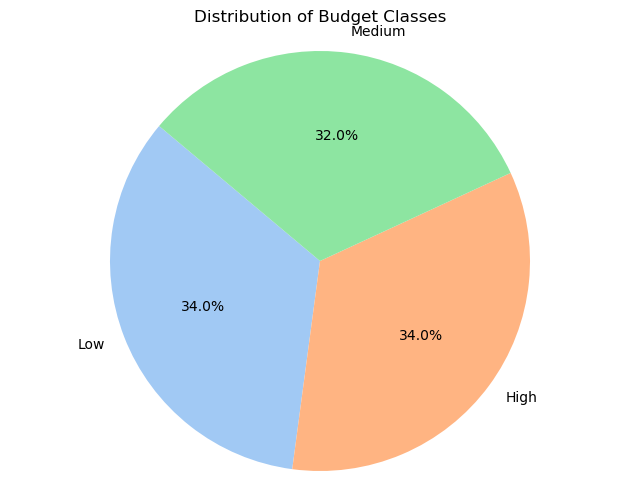

In [ ]:
# Pie chart for Budget_Class distribution
budget_class_counts = df['Budget_Class'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
plt.pie(
    budget_class_counts,
    labels=budget_class_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel')
)
plt.title('Distribution of Budget Classes')
plt.axis('equal')  # Ensures pie is a circle
plt.show()


In [ ]:
print(df.columns)


Index(['College_Name', 'Enrollment', 'Faculty_Count', 'Total_Budget', 'Year',
       'Budget_per_Student', 'Student_Faculty_Ratio', 'State_Karnataka',
       'State_Maharashtra', 'State_Tamil Nadu', 'State_West Bengal',
       'College_Type_Private', 'Predicted_Budget', 'Budget_Deficit',
       'Budget_Class'],
      dtype='object')


In [ ]:
from prophet import Prophet
import pandas as pd

# Assume df has 'Year' and 'Total_Budget'
df_prophet = df[['Year', 'Total_Budget']].copy()

# Convert Year to datetime if it's not already
df_prophet['ds'] = pd.to_datetime(df_prophet['Year'], format='%Y')
df_prophet['y'] = df_prophet['Total_Budget']

# Drop original columns
df_prophet = df_prophet[['ds', 'y']]


In [ ]:
# Check for missing values
print(df_prophet.isna().sum())

# Drop rows with any NaNs just before fitting the model
df_prophet_clean = df_prophet.dropna()

# Optionally: ensure 'ds' is datetime and sorted
df_prophet_clean['ds'] = pd.to_datetime(df_prophet_clean['ds'])
df_prophet_clean = df_prophet_clean.sort_values('ds')

# Fit model
from prophet import Prophet
model = Prophet()
model.fit(df_prophet_clean)


ds    0
y     0
dtype: int64


02:15:38 - cmdstanpy - INFO - Chain [1] start processing
02:15:39 - cmdstanpy - INFO - Chain [1] done processing


02:07:02 - cmdstanpy - INFO - Chain [1] start processing
02:07:04 - cmdstanpy - INFO - Chain [1] done processing


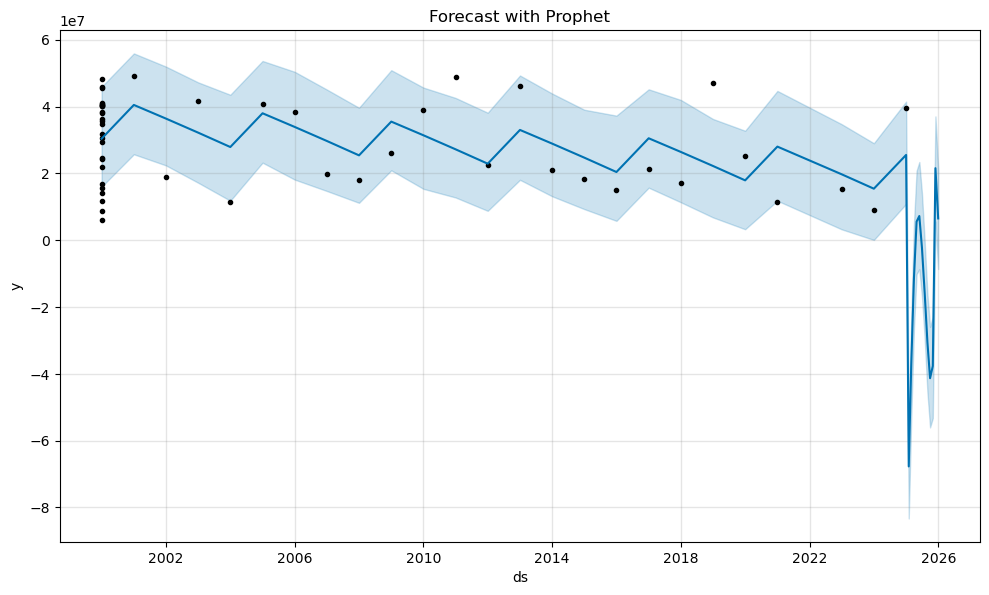

In [ ]:
from prophet import Prophet
import pandas as pd

# Assuming df_prophet is your DataFrame and has columns 'ds' (datetime) and 'y' (value to forecast)
# Example:
# df_prophet = pd.DataFrame({
#     'ds': pd.date_range(start='2020-01-01', periods=50, freq='M'),
#     'y': np.random.rand(50) * 100
# })

# 1. Initialize and fit the model
model = Prophet()
model.fit(df_prophet)

# 2. Create a future dataframe (e.g., for 12 months)
future = model.make_future_dataframe(periods=12, freq='MS')  # use month start
# OR
future = model.make_future_dataframe(periods=12, freq='ME')  # new month end

# 3. Predict
forecast = model.predict(future)

# 4. Plot results
model.plot(forecast)
plt.title("Forecast with Prophet")
plt.show()


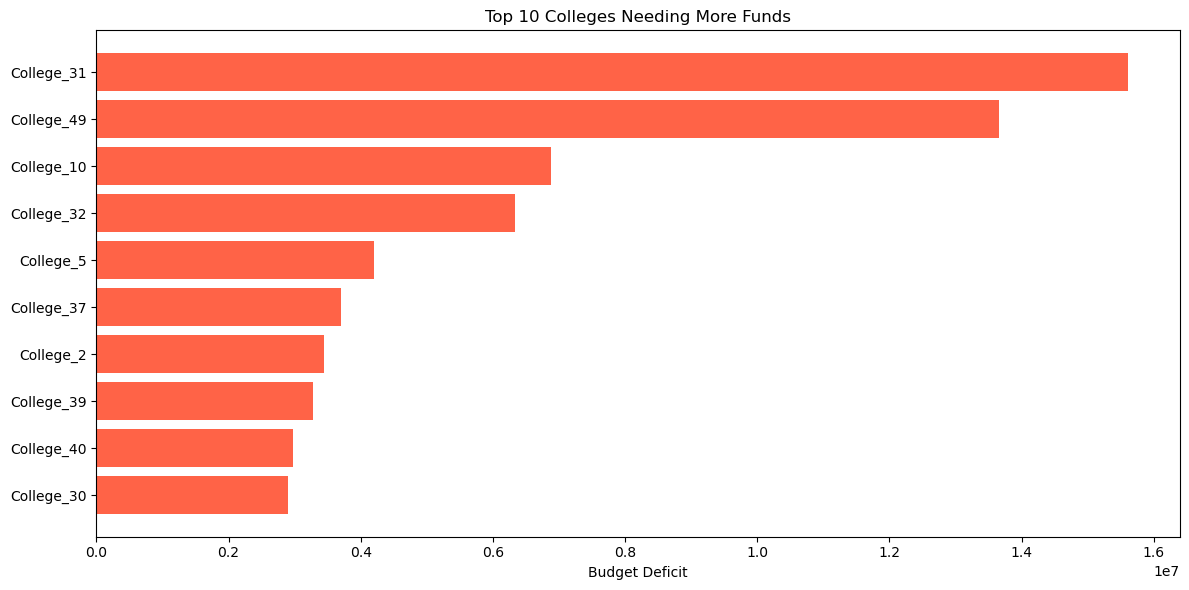

In [ ]:
import matplotlib.pyplot as plt

# Plotting Top 10 colleges needing more funds
top10 = deficit_colleges.head(10)
plt.figure(figsize=(12, 6))
plt.barh(top10['College_Name'], top10['Budget_Deficit'], color='tomato')
plt.xlabel('Budget Deficit')
plt.title('Top 10 Colleges Needing More Funds')
plt.gca().invert_yaxis()  # So the largest deficit is on top
plt.tight_layout()
plt.show()


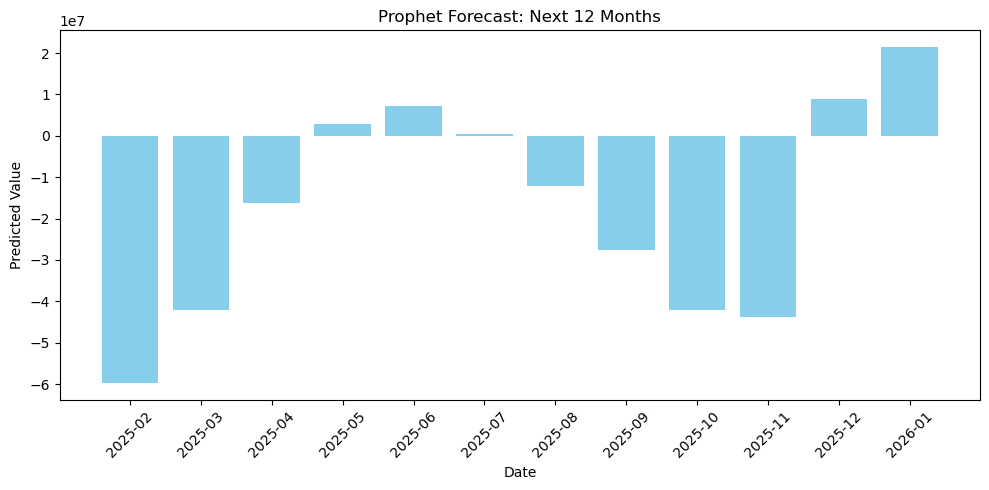

In [ ]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Bar chart of forecast values
forecast_tail = forecast.tail(12)  # Last 12 predictions
plt.figure(figsize=(10, 5))
plt.bar(forecast_tail['ds'].dt.strftime('%Y-%m'), forecast_tail['yhat'], color='skyblue')
plt.title("Prophet Forecast: Next 12 Months")
plt.xlabel("Date")
plt.ylabel("Predicted Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
streamlit run app.py


In [ ]:
def get_user_input():
    print("\nEnter the following details:")
    enrollment = float(input("Enrollment: "))
    faculty_count = float(input("Faculty Count: "))
    state = input("State (e.g., 'CA', 'NY'): ")
    college_type = input("College Type (e.g., 'Public', 'Private'): ")

    # Derived features
    budget_per_student = 0  # Placeholder if Total_Budget is unknown
    student_faculty_ratio = enrollment / faculty_count

    # Base feature dictionary
    data = {
        'Enrollment': enrollment,
        'Faculty_Count': faculty_count,
        'Budget_per_Student': budget_per_student,
        'Student_Faculty_Ratio': student_faculty_ratio,
    }

    # Add dummy variables
    for col in df_new.columns:
        if 'State_' in col:
            data[col] = 1 if col == f"State_{state}" else 0
        elif 'College_Type_' in col:
            data[col] = 1 if col == f"College_Type_{college_type}" else 0

    return pd.DataFrame([data])

# Take user input
user_df = get_user_input()

# Ensure all training features are present
for col in model.feature_names_in_:
    if col not in user_df.columns:
        user_df[col] = 0
user_df = user_df[model.feature_names_in_]

# Scale and predict
user_scaled = scaler.transform(user_df)
prediction = model.predict(user_scaled)

print(f"\nPredicted Budget: ${prediction[0]:,.2f}")



Enter the following details:


KeyboardInterrupt: Interrupted by user